### Load Imports

In [8]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Preprocess The data

In [9]:
# Load the dataset
data = pd.read_csv("cleveland.csv")
# Preprocess the data
data["num"] = data["num"].apply(lambda x: 1 if x > 0 else 0)
# Change num column name to make more sense
data = data.rename({'num':'disease'}, axis=1)

data.replace('?', pd.NA, inplace=True)
# TODO: may want replace ? with the mode of the column
data.dropna(inplace=True)

non_numeric_columns = data.select_dtypes(exclude=['number']).columns
for col in non_numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

data.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


### Define K-Nearest Neighbor Model

In [10]:
class MyKNN:
    def __init__(self, k=5, dist_metric='euclidean'):
        self.k = k
        self.dist_metric = dist_metric
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def compute_distance(self, x1, x2):
        if self.dist_metric == 'euclidean':
            return np.sqrt(np.sum((x1 - x2) ** 2))
        elif self.dist_metric == 'manhattan':
            return np.sum(np.abs(x1 - x2))
        
    def predict(self, X_test):
        y_pred = []
        for x in X_test:
            distances = [self.compute_distance(x, x_train) for x_train in self.X_train]
            sorted_indices = sorted(range(len(distances)), key=lambda i: distances[i])
            k_indices = sorted_indices[:self.k]
            k_nearest_labels = [self.y_train[i] for i in k_indices]
            y_pred_fold = self.most_common(k_nearest_labels)
            # Append the predicted label to y_pred
            y_pred.append(y_pred_fold)
        # Convert y_pred to numpy array for compatibility with evaluation functions
        y_pred = np.array(y_pred)
        return y_pred
    
    def most_common(self, lst):
        return max(set(lst), key=lst.count)

    def evaluate(self, X_test, y_test):
        y_pred, precision_scores, recall_scores, f1_scores = self.predict(X_test)
        # Print precision, recall, and F1 scores for each fold
        for i in range(len(precision_scores)):
            print(f"Fold {i+1}: Precision = {precision_scores[i]}, Recall = {recall_scores[i]}, F1 Score = {f1_scores[i]}")
        # Compute mean precision, recall, and F1 scores
        mean_precision = np.mean(precision_scores)
        mean_recall = np.mean(recall_scores)
        mean_f1 = np.mean(f1_scores)
        # Print mean precision, recall, and F1 scores
        print(f"Mean Precision: {mean_precision}, Mean Recall: {mean_recall}, Mean F1 Score: {mean_f1}")
        return mean_precision, mean_recall, mean_f1
    
    def get_params(self, deep=True):
        return {'k': self.k, 'dist_metric': self.dist_metric}
    
    def set_params(self, **params):
        if 'k' in params:
            self.k = params['k']
        if 'dist_metric' in params:
            self.dist_metric = params['dist_metric']
        return self

### Find Best Number and Combination Of Features to Use

Best F1 Score: 0.8888888888888888 with 8 features selected.
Best Feature Combination: ['age' 'cp' 'trestbps' 'chol' 'thalach' 'oldpeak' 'ca' 'thal']


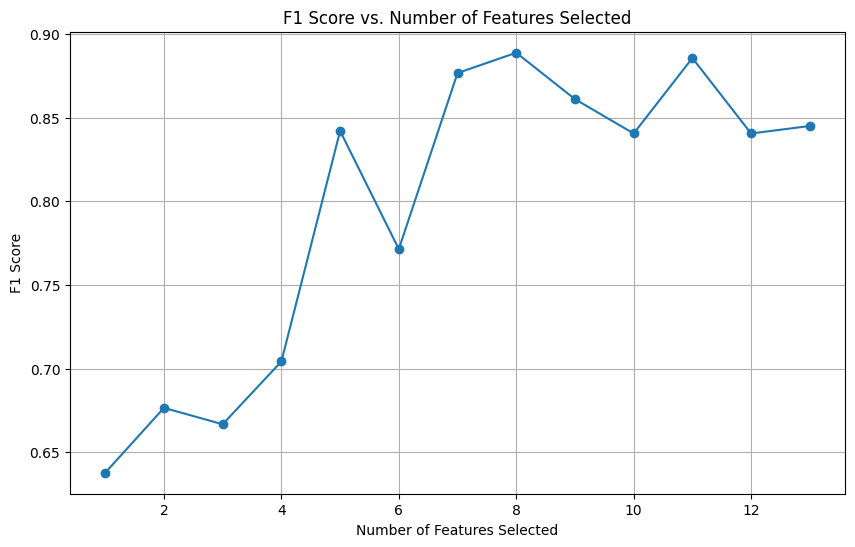

In [11]:
# Choose Features
features = ["age","sex","cp","trestbps","chol",
            "fbs","restecg","thalach","exang",
            "oldpeak","slope","ca","thal"] # all features
# Split features and target variable
X = data[features].values
y = data["disease"].values
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Define the estimator (model) to be used
estimator = RandomForestClassifier(n_estimators=100)
# Define the range of number of features to test
num_features_range = range(1, len(features) + 1)  # Test from 1 to the total number of features
# Initialize lists to store results
best_feature_combination = []
best_f1_score = 0
feature_scores = []
f1_scores = []

# Loop over different numbers of features
for num_features_to_select in num_features_range:
    # Initialize RFE with the chosen estimator and number of features to select
    rfe = RFE(estimator, n_features_to_select=num_features_to_select)
    # Fit RFE to the training data
    rfe.fit(X_train, y_train)
    # Get the selected features
    selected_features = np.array(features)[rfe.support_]
    # Get the transformed training and testing data with selected features
    X_train_selected = rfe.transform(X_train)
    X_test_selected = rfe.transform(X_test)
    # Train the model using selected features
    estimator.fit(X_train_selected, y_train)
    # Make predictions on the testing data
    y_pred = estimator.predict(X_test_selected)
    # Calculate F1 score
    f1 = f1_score(y_test, y_pred)
    # Append results to lists
    feature_scores.append(num_features_to_select)
    f1_scores.append(f1)
    # Update best feature combination if current F1 score is better
    if f1 > best_f1_score:
        best_f1_score = f1
        best_feature_combination = selected_features

# Find the index of the maximum F1 score
best_f1_index = np.argmax(f1_scores)
best_num_features = feature_scores[best_f1_index]
best_f1_score = f1_scores[best_f1_index]

print(f"Best F1 Score: {best_f1_score} with {best_num_features} features selected.")
print("Best Feature Combination:", best_feature_combination)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(feature_scores, f1_scores, marker='o')
plt.xlabel('Number of Features Selected')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Number of Features Selected')
plt.grid(True)
plt.show()

### Split Data Up On the Best Features

In [12]:
X = data[best_feature_combination].values
y = data["disease"].values
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### Find the Best Amount of K-Neighbors to Use

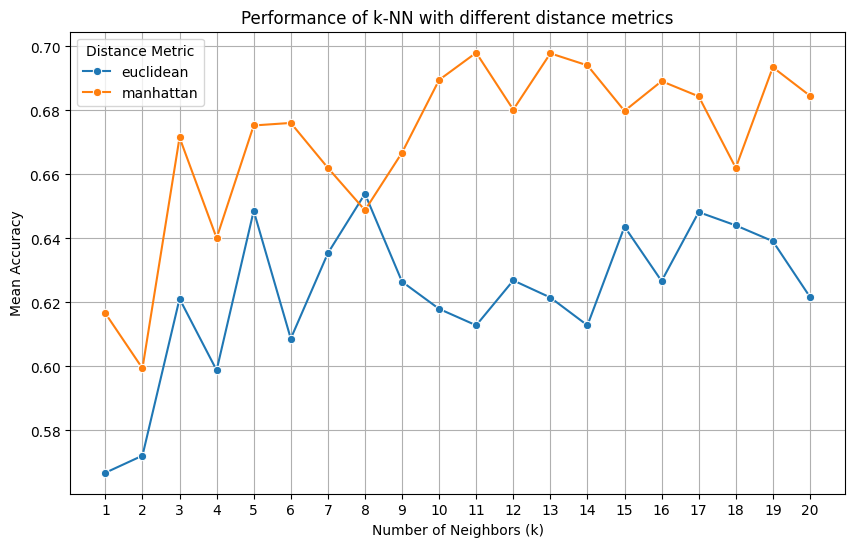

Best parameters: {'dist_metric': 'manhattan', 'k': 11}



In [13]:
krange = range(1,21)
# Define the parameter grid for GridSearchCV
param_grid = {
    'k': krange,
    'dist_metric': ['euclidean', 'manhattan'],
}

# Create an instance of MyKNN
knn = MyKNN()
# Create GridSearchCV object
cv_num = 10
grid_search = GridSearchCV(knn, param_grid, cv=cv_num, scoring='accuracy')
# Fit the model to the training data
grid_search.fit(X_train, y_train)
# Extract results from the grid search
results = grid_search.cv_results_
mean_test_scores = results['mean_test_score']
params = results['params']
data_results = pd.DataFrame({
    'k_values': [p['k'] for p in params],  # Extract k values
    'dist_metric': [p['dist_metric'] for p in params],  # Extract distance metrics
    'mean_accuracy': mean_test_scores  # Mean accuracy scores
})

# Plot Scores
plt.figure(figsize=(10, 6))
sns.lineplot(data=data_results, x='k_values', y='mean_accuracy', hue='dist_metric', marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Accuracy')
plt.title('Performance of k-NN with different distance metrics')
plt.grid(True)
plt.xticks(krange)
plt.legend(title='Distance Metric')
plt.show()

# Perform cross-validation with the best parameters
best_params = grid_search.best_params_
best_k = best_params['k']
best_dist_metric = best_params['dist_metric']
print(f"Best parameters: {best_params}\n")

### Use Best Parameters and Preform 10-Fold Cross-Validation

In [14]:
knn_best = MyKNN(k=best_k, dist_metric=best_dist_metric)
cv_scores = cross_val_score(knn_best, X_train, y_train, cv=cv_num, scoring='accuracy')
cv = KFold(n_splits=cv_num, shuffle=True)
precision_scores = []
recall_scores = []
f1_scores = []
# Print precision, recall, and F1 scores for each fold during cross-validation
for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X_train)):
    X_train_fold, X_test_fold = X_train[train_idx], X_train[test_idx]
    y_train_fold, y_test_fold = y_train[train_idx], y_train[test_idx]
    knn_best.fit(X_train_fold, y_train_fold)
    y_pred_fold = knn_best.predict(X_test_fold)
    precision_fold = precision_score(y_test_fold, y_pred_fold)
    recall_fold = recall_score(y_test_fold, y_pred_fold)
    f1_fold = f1_score(y_test_fold, y_pred_fold)
    print(f"Fold {fold_idx + 1}: Precision = {precision_fold}, Recall = {recall_fold}, F1 Score = {f1_fold}")# Append the scores to the respective lists
    precision_scores.append(precision_fold)
    recall_scores.append(recall_fold)
    f1_scores.append(f1_fold)

# Calculate the mean precision, recall, and F1 score
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)

# Print the mean precision, recall, and F1 score
print(f"\nMean Precision: {mean_precision}")
print(f"Mean Recall: {mean_recall}")
print(f"Mean F1 Score: {mean_f1}")

Fold 1: Precision = 0.5, Recall = 0.3076923076923077, F1 Score = 0.380952380952381
Fold 2: Precision = 0.8181818181818182, Recall = 0.8181818181818182, F1 Score = 0.8181818181818182
Fold 3: Precision = 0.7777777777777778, Recall = 0.7, F1 Score = 0.7368421052631577
Fold 4: Precision = 0.6, Recall = 0.6, F1 Score = 0.6
Fold 5: Precision = 0.9, Recall = 0.8181818181818182, F1 Score = 0.8571428571428572
Fold 6: Precision = 0.375, Recall = 0.3333333333333333, F1 Score = 0.35294117647058826
Fold 7: Precision = 0.6666666666666666, Recall = 0.9090909090909091, F1 Score = 0.7692307692307692
Fold 8: Precision = 0.45454545454545453, Recall = 0.5555555555555556, F1 Score = 0.5
Fold 9: Precision = 1.0, Recall = 0.6363636363636364, F1 Score = 0.7777777777777778
Fold 10: Precision = 0.6666666666666666, Recall = 0.5454545454545454, F1 Score = 0.6

Mean Precision: 0.6758838383838384
Mean Recall: 0.6223853923853924
Mean F1 Score: 0.6393068885019348
